In [1]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import re
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from model.utils import *

Done! Loaded utils.py


# Part 1 Pre-Processing

## Labeling Sample

| seq | text                                                                                                                                                         | label     |
|-----|--------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------|
| 74  | @116062: will you create a “disaster registry” where fire victims can pick the items they need and anyone can fill them? Offer discounts?                    | pricing   |
| 75  | "@AppleSupport Freezing basically all of the time. Apps are messing up, if i turn on airplane mode and then turn it off i can’t get service without restart" | technical |
| 76  | @VirginTrains I’ve lost my tkt back to Wilmslow. I’ve got receipt and it’s on my app but your staff tell me too bad. Surely not right??                      | technical |
| 77  | @AmazonHelp I ordered a package to be delivered tomorrow but I’ve had a notification saying it’ll be a day late now                                          | delivery  |
| 78  | "@AmazonHelp prime membership says it’s suspended, updated payment method but still says it’s suspended? How do I fix it to get Prime back?"                 | payment   |


In [2]:
df_origin = pd.read_csv(f"{ASSETS}labeled_L2__bucket_sampled.csv")
df_origin.head(10)

,tweet_id,text,label
0,2167038,"#Netflix members, beware: Don’t get tricked by...",legal
1,1696874,"@AppleSupport Just saying, but next time I won...",legal
2,46005,@115714 should fire every last call center wor...,legal
3,2885597,@115783 @AirbnbHelp \nSeems now you don’t have...,legal
4,989846,@AmazonHelp I had excellent exp with amazon in...,legal
5,596057,@AskeBay how comes when on Ebay site I keep ge...,legal
6,2471615,@sainsburys Need to DM you + screenshot re an ...,legal
7,2474403,telling someone trying to scam me over the pho...,legal
8,1079368,@AmazonHelp Concern regarding Amazon pay balan...,legal
9,1737558,this is a weird and new scam @115783 someone w...,legal


In [3]:
def clean_text(txt):
    txt = txt.lower()
    txt = re.sub(r"http\S+", "", txt)  # remove URLs
    txt = re.sub(r"@\w+", "", txt)  # remove @handles
    txt = re.sub(r"[^a-z\s]", " ", txt)  # keep only letters and spaces
    txt = re.sub(r"\s+", " ", txt).strip()  # collapse multiple spaces

    return txt

In [4]:
df_origin['clean_text'] = df_origin['text'].astype(str).apply(clean_text)
df_origin.head(10)

,tweet_id,text,label,clean_text
0,2167038,"#Netflix members, beware: Don’t get tricked by...",legal,netflix members beware don t get tricked by th...
1,1696874,"@AppleSupport Just saying, but next time I won...",legal,just saying but next time i won t say anything...
2,46005,@115714 should fire every last call center wor...,legal,should fire every last call center worker they...
3,2885597,@115783 @AirbnbHelp \nSeems now you don’t have...,legal,seems now you don t have to worry about strict...
4,989846,@AmazonHelp I had excellent exp with amazon in...,legal,i had excellent exp with amazon in past but th...
5,596057,@AskeBay how comes when on Ebay site I keep ge...,legal,how comes when on ebay site i keep getting sca...
6,2471615,@sainsburys Need to DM you + screenshot re an ...,legal,need to dm you screenshot re an email voucher ...
7,2474403,telling someone trying to scam me over the pho...,legal,telling someone trying to scam me over the pho...
8,1079368,@AmazonHelp Concern regarding Amazon pay balan...,legal,concern regarding amazon pay balance issues n ...
9,1737558,this is a weird and new scam @115783 someone w...,legal,this is a weird and new scam someone who s req...


# Part 2 Feature Engineering 

## Todo

- 使用 TF-IDF 向量化文本
- 采用 装袋（Bagging）策略
  - 从主数据中随机采样10组子集
  - 每组单独构造一个 TF-IDF 特征空间
  - 每组都可作为一次训练任务

In [40]:
# Bagging Optional
# Todo Mark Bagging未启用
# def generate_bagged_tfidf_sets(
#         df, 
#         text_col='clean_text', 
#         label_col='label', 
#         n_bags=10, 
#         sample_frac=0.7, 
#         max_features=1000, 
#         customstop_words=None, 
#         random_state=42):
#     """
#     从清洗后的df中采样构造TF-IDF特征组，用于Bagging建模。
#     返回：X_list（稀疏矩阵列表）, y_list（标签数组列表）
#     """
#     X_list = []
#     y_list = []
#     
#     label_encoder = LabelEncoder()
#     df = df.copy()
#     df[label_col] = label_encoder.fit_transform(df[label_col].astype(str))
# 
#     for i in range(n_bags):
#         df_sample = df.sample(frac=sample_frac, random_state=random_state + i)
#         tfidf = TfidfVectorizer(customstop_words=customstop_words, max_features=max_features)
#         X = tfidf.fit_transform(df_sample[text_col])
#         y = df_sample[label_col].values
# 
#         X_list.append(X)
#         y_list.append(y)
# 
#     return X_list, y_list, label_encoder.classes_

In [41]:
# 10组稀疏特征训练集
# X_list, y_list, label_names = generate_bagged_tfidf_sets(df_origin)
# print(label_names)

# Part 3 Training & Testing

| category of risk            | description                     |
|-----------------------------|---------------------------------|
| technical                   | 系统/技术故障，如崩溃、报错                  |
| payment                     | 扣费异常、支付失败                       |
| delivery                    | 配送延误、丢件、送错货等                    |
| account                     | 账号冻结、登录失败、权限问题                  |
| service                     | 客服响应慢、客服态度差等                    |
| pricing                     | 价格争议、不一致                        |
| legal                       | 版权、虚假宣传、数据泄露、违法行为               |



In [5]:
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS

combined_stopwords = list(ENGLISH_STOP_WORDS.union(custom_stop_words))

tfidf = TfidfVectorizer(
    stop_words=combined_stopwords,
    lowercase=True,
    token_pattern=r"(?u)\b\w+\b",
    max_features=1000
)

X = tfidf.fit_transform(df_origin['clean_text'])
le = LabelEncoder()
y = le.fit_transform(df_origin['label'].values)

In [6]:
# Mark 重要，保持标签名和顺序绑定一致，用于所有图表
ordered_label_names = RiskLabel.get_names()[0:7]
print(ordered_label_names)

['legal', 'account', 'payment', 'technical', 'delivery', 'service', 'pricing']


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    stratify=y, 
    test_size=0.2, 
    random_state=42
)

# 训练
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

/Users/Matthew/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:33:02] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [8]:
# 分支任务，划分训练集之前保留分词向量原文本，用于识别错分任务
# 暂保留 clean_text 原文列
df_origin["label_id"] = y  # 加入编码后的标签
df_origin["tfidf_vector"] = list(X.toarray())

df_train, df_test = train_test_split(df_origin, test_size=0.2, stratify=df_origin["label_id"], random_state=42)

X_train = tfidf.transform(df_train["clean_text"])
X_test = tfidf.transform(df_test["clean_text"])

y_train = df_train["label_id"]
y_test = df_test["label_id"]

# 预测
y_pred = model.predict(X_test)

# 标记
mask = y_pred != y_test

# 错误样本
df_miss = df_test[mask].copy()
df_miss["predicted"] = y_pred[mask]

df_miss[["clean_text", "label_id", "predicted"]].head(10)

df_miss["true_label"] = le.inverse_transform(df_miss["label_id"])
df_miss["pred_label"] = le.inverse_transform(df_miss["predicted"])

df_miss = df_miss[["tweet_id", "clean_text", "true_label", "pred_label"]]

df_miss.head(200).to_csv(f"{ASSETS}missed_label_200.csv", index=False, encoding='utf-8-sig')

df_miss.head(10)

,tweet_id,clean_text,true_label,pred_label
1358,173189,i have been on hold a total of minutes spoken ...,payment,technical
4893,2040404,what is with airlines and their huge attitude ...,delivery,service
797,2595768,hi stephanie so sorry to hear that not quite s...,payment,delivery
430,704620,hi i lost my phone yesterday in an uber car th...,account,delivery
7045,1177131,traveling from linate milan airport on and i h...,service,delivery
7205,2171282,serious question why do you offer us the optio...,service,delivery
19,2606613,used to use pro dashboard for manag g clients ...,legal,delivery
109,249809,now that it seems the services has been deacti...,legal,payment
3070,346691,worst experience with verizon mins to speak w ...,technical,service
75,2879074,giving you guys a heads up scammers are callin...,legal,delivery


In [10]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=ordered_label_names))

              precision    recall  f1-score   support

       legal       1.00      0.85      0.92        48
     account       0.94      0.99      0.96       478
     payment       1.00      0.73      0.84        44
   technical       0.99      0.96      0.98       318
    delivery       0.94      0.81      0.87        21
     service       0.96      0.97      0.97       258
     pricing       0.97      0.98      0.97       378

    accuracy                           0.96      1545
   macro avg       0.97      0.90      0.93      1545
weighted avg       0.96      0.96      0.96      1545



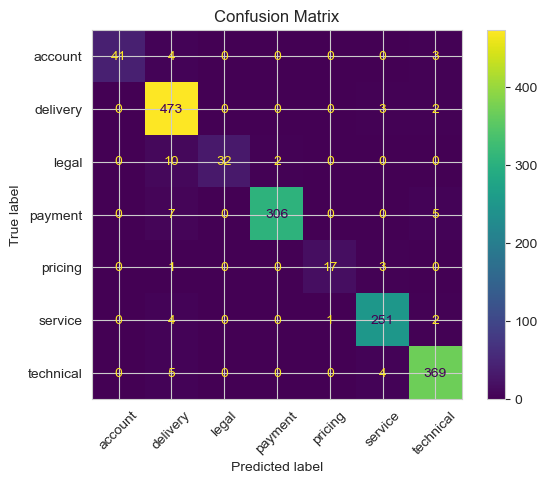

In [11]:
# 软换标签由编码到文字
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=le.classes_)
disp.ax_.set_title("Confusion Matrix")
plt.xticks(rotation=45)
plt.savefig("../../plot/Confusion Matrix.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [12]:
save_predictions(y_test, y_pred, f'{ASSETS}y_true_pred.pkl')

Predictions saved to ../../assets/y_true_pred.pkl


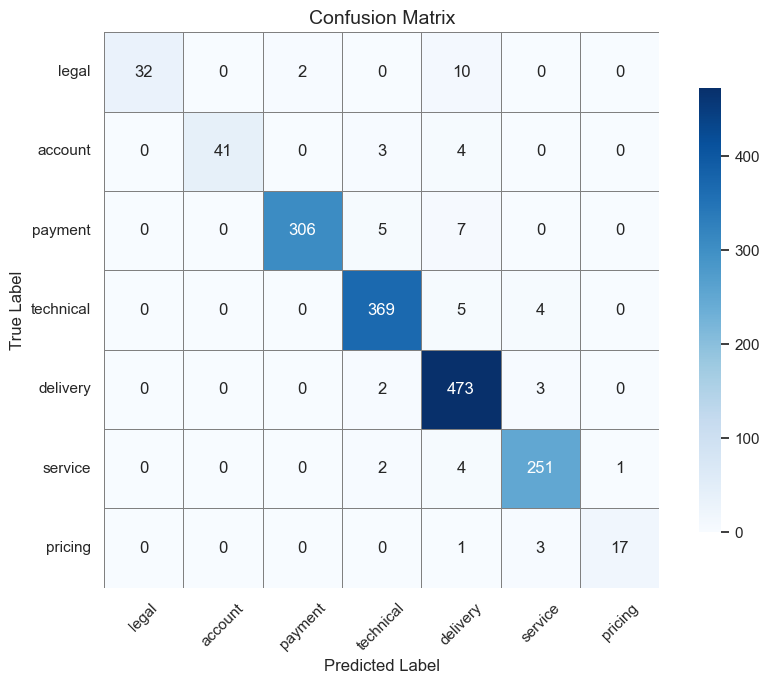

In [13]:
# Seaborn
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 获取 confusion matrix（按 label 名称传入）
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=ordered_label_names)

# 创建 DataFrame 以匹配 sns.heatmap
df_cm = pd.DataFrame(cm, index=ordered_label_names, columns=ordered_label_names)

plt.figure(figsize=(9, 7))
sns.set(font_scale=1.0)
sns.heatmap(
    df_cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',          
    linewidths=0.5, 
    linecolor='gray', 
    square=True,
    cbar_kws={'shrink': 0.8}
)

plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("../../plot/Confusion Matrix.png", dpi=120, bbox_inches='tight')
plt.show()

In [14]:
# 错误样本分析

# 统一为Series（防止索引不一致）
y_test_series = pd.Series(y_test).reset_index(drop=True)
y_pred_series = pd.Series(y_pred).reset_index(drop=True)

# 如果 X_test 是文本/一列
X_test_series = X_test[:, 0].reset_index(drop=True)

# 错误样本 
mask = y_test_series != y_pred_series

# 抽出错误样本
df_misclassified = pd.DataFrame({
    "Text": X_test_series[mask],
    "True Label": y_test_series[mask],
    "Predicted Label": y_pred_series[mask]
})

df_misclassified.head(10)

AttributeError: 'csr_matrix' object has no attribute 'reset_index'